In [15]:
import sys
import os

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/WCTE_BRB_Data_Analysis"))
sys.path.append(os.path.abspath("/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/nHits_trigger"))
sys.path.append("/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/hipy")
sys.path.append("/home/usc/ie/dcr/hk/ambe_analysis")

# Import Diego's tools
from paquetes.npz_to_df import truehits_info_to_df
from paquetes.npz_to_df import simple_track_info_to_df

import hipy.pltext       as pltext
import hipy.utils        as ut
import matplotlib.pyplot as plt
import awkward           as ak
import numpy             as np
import pandas            as pd

from src.read_data                   import load_concatenated, read_parquet, nHits
from tqdm.notebook                   import tqdm

%load_ext autoreload
%autoreload 2

pltext.style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
npz     = '/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/WCSim/install/nicfVec_0kHz_NOTRIGGER_50kevents_actualPrototype.npz'
nevents = 50000

# Creación del DataFrame de DigiHits usando la función digihits_info_to_df
df_trueHits = truehits_info_to_df(npz)
df_simpleTracks = simple_track_info_to_df(npz)

In [7]:
df_trueHits

,event_id,true_hit_parent,true_hit_pmt,true_hit_time,true_hit_start_time,hit_x,hit_y,hit_z,hit_start_x,hit_start_y,hit_start_z,true_hit_creatorProcess,hit_r,hit_start_r
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,8,1801,7.725062,1.784413,-5.836419,135.115128,99.28743,-9.988919,11.473467,61.445007,Cerenkov,167.774120,63.300141
1,1,8,1664,9.098529,1.78649,47.053452,134.587173,71.08123,-9.975455,11.501704,61.470253,Cerenkov,159.311882,63.327647
1,1,82,776,67162911906979751437271040.0,67162911906979751437271040.0,-2.620486,-116.460571,-152.337265,22.966244,-33.137585,-44.26717,Cerenkov,191.772193,59.875957
1,1,82,1019,67162911906979751437271040.0,67162911906979751437271040.0,-17.469955,-135.72049,-64.299248,22.954311,-33.079155,-44.252098,Cerenkov,151.194060,59.827912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,46,1019,134813555727268383419269120.0,134813555727268383419269120.0,-15.405095,-134.523804,-68.154205,42.161995,-58.297218,-113.550049,Cerenkov,151.588147,134.424005
49996,49996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49997,49997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49998,49998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
grouped_times = (
    df_trueHits.groupby("event_id")["true_hit_time"]
    .apply(list)
    .loc[lambda x: ~x.apply(lambda l: len(l) == 1 and pd.isna(l[0]))]
    .tolist()
)

In [17]:
grouped_times = ak.Array(grouped_times)
grouped_times

<Array [[7.73, 9.1, ..., 6.72e+25, 6.72e+25], ...] type='20692 * var * float64'>

In [18]:
hit_times = ak.sort(grouped_times)
hit_times

<Array [[7.73, 9.1, ..., 6.72e+25, 6.72e+25], ...] type='20692 * var * float64'>

In [44]:
thresholds   = [4,5,6,7,8,9,10,11,12]
exp_values = []

for thresh in thresholds:
    triggered_hits_index = nHits(hit_times, w=50, thresh_min=thresh, thresh_max=160, pre_window=50, post_window=50, jump=15000, progress_bar=False)
    noTriggers_per_event = []
    for key in triggered_hits_index.keys():
        noTriggers_per_event.append(len(triggered_hits_index.get(key)))
    
    exp_values.append(ut.stats(noTriggers_per_event)[1:3])

  0%|          | 0/20692 [00:00<?, ?it/s]

In [45]:
sim_entries = [405, 318, 241, 186, 147, 120, 98, 84, 73]
theo_values = [500e-6/(1/(i/1e4*3.7e5)) for i in sim_entries]

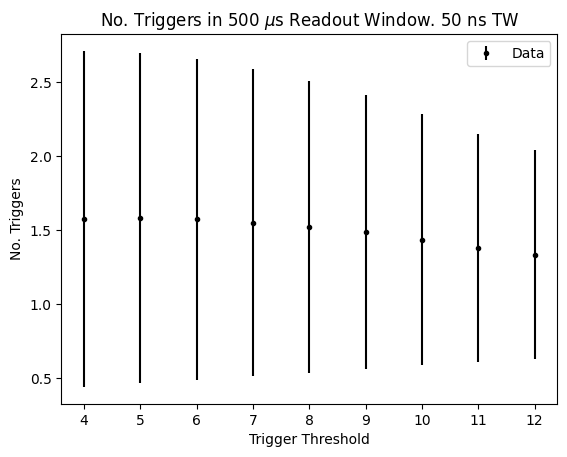

In [48]:
means = [i[0] for i in exp_values]
stds  = [i[1] for i in exp_values]

plt.errorbar(thresholds, means, stds, fmt=".", label=f"Data");
# plt.scatter(thresholds, theo_values, marker=".", color="red", zorder=2, label="WCSim");
# plt.text(6.6, 5.4, "Trigger Window: 50 ns");

plt.xlabel("Trigger Threshold");
plt.ylabel("No. Triggers");
plt.title("No. Triggers in 500 $\mu$s Readout Window. 50 ns TW");
plt.legend();

In [47]:
means

[1.57526421022565,
 1.5803149606299214,
 1.572232645403377,
 1.5491096016155683,
 1.5225983173547255,
 1.4855698335791025,
 1.43600721045516,
 1.3806749210973532,
 1.3340419877757108]